# CM 50270 Reinforcement Learning: Coursework 2 

**Date set:** March 12, 2018 

**Date due:** 8 pm on March 21, 2018 

**Total number of marks:** 100. (This coursework will determine 20% of your final grade for CM 50270.)

**What to submit:** Completed Jupyter notebook (.ipynb file) that includes all source code. Please do not change the file name.

**Where to submit:** CM50270 Moodle page

This coursework will be __marked anonymously__. Please do not include any identifying information on the files you submit. 

You are required to __work individually__. You are welcome to discuss ideas with others but you must design your own implementation and write your own code.

__Do not plagiarise__. Plagiarism is a serious academic offence. For details on what it is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.

Remember to save your work regularly. 

## Exercise 1: Blackjack (20 marks)

In this first exercise, you will implement **Monte Carlo Policy Evaluation (MCPE)** to learn the state-value function $V(s)$ for a given policy in the game of [blackjack](https://en.wikipedia.org/wiki/Blackjack).

### The game

**Rules.** We will use the version of the game discussed in the lectures where a single player (the agent) plays against the dealer. The player's objective is to obtain cards whose sum is as large as possible without exceeding 21. All face cards count as 10; an ace can count as either 1 or 11.

The game begins with two cards dealt to both the dealer and the player. The first of the dealer’s cards is face down and the second is face up. If the player has 21 immediately (for example, an ace and a face card), it is called a "blackjack". The player then wins unless the dealer also has a blackjack, in which case the game is a draw. If the player does not have a blackjack, then she can request additional cards, one by one (_hits_), until she either stops (_sticks_) or exceeds 21 (_goes bust_). If the player goes bust, she loses; if she sticks, then it becomes the dealer’s turn. 

The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome (win, lose, or draw) is determined by whose final sum is closer to 21.

**MDP formulation.** Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards until the end of the game are zero. We do not discount ($\gamma = 1$); therefore these terminal rewards are also the returns. The player’s actions are to `"hit"` or to `"stick"`. 

The states depend on the player’s cards and the dealer’s showing card. Assume that cards are dealt from an infinite deck (that is, with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that she could count as 11 without going bust, then the ace is said to be _usable_. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: 
- the player's current sum (an integer between 12 and 21);
- the dealer’s one showing card (an integer between 1 and 10; note that the ace is counted as 1 here); and
- whether or not the player holds a usable ace (a boolean). 

This makes for a total of 200 states. We represent the state as a numpy-array of length 3 that combines the just mentioned three variables in the given order. For example, if the player is given a 6 and a _jack_, and the dealer's showing card is an ace, the corresponding state will be the numpy array `[16, 1, False]`. The terminal state of the game will be denoted by the numpy array `[-1, -1, -1]`.

###  Blackjack code you may use if you wish

** Please feel free to skip this section and implement your own blackjack code **

We provide a `Blackjack` class that you can use to simulate blackjack games. The following cells in this section will walk you through the basic usage of this class by playing a couple of blackjack games.  

We import the blackjack module and create a blackjack environmnet called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the blackjack object will regularly print the progress of the game. This is useful for getting to know the game and the provided code or if you just want to play around. You may want to set `verbose=False` when you run thousands of episodes to complete the exercise below.

In [1]:
import blackjack
env = blackjack.Blackjack(verbose=True)

You can interact with the blackjack environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. Specifically, this method returns the resulting `new_state` and the corresponding `reward` signal.

Before the player can perform actions, we have to start the game (e.g., draw starting hands). In order to start or reset a blackjack game, call the `make_step()` without specifying a specific action or by setting `action="reset"`.

We will now walk through several example games. We will specify a [random seed](https://en.wikipedia.org/wiki/Random_seed) for the NumPy pseudo random number generator every time before we reset the game. This allows us to keep these examples reproducible.

In [2]:
import numpy as np
np.random.seed(8)
new_state, reward = env.make_step(action="reset")
print("Initial state:", new_state)
print("Reward:", reward)

The game is reset.
Player's cards: [10, 10]
Dealer's showing card: [7]
Initial state: [20  7  0]
Reward: 0


The player drew two cards with face value 10 each. The dealer also drew two cards, but we can only see the second card, a 7. The player now can choose to "hit" or "stick". Most players would stick if they had 20 on their hand. We call again the `make_step()` method and specify `action="stick"`.

In [3]:
new_state, reward = env.make_step(action = "stick")
print("The player obtains a reward of", reward)
print("The new (terminal) state is:", new_state)

The dealer's cards are: [10, 7]
The dealer has 17 points.
PLAYER WINS!
The player obtains a reward of 1
The new (terminal) state is: [-1 -1 -1]


The player won and received a reward of 1. Whenever an episode ends, the environment object sets the internal variable `self.active` to `False`. This variable is set to `True` again when we _reset_ the game. You can use the `self.active` variable to check whether an episode has ended or not.

In [4]:
np.random.seed(9)
new_state, reward = env.make_step(action="reset")
print("New state:", new_state)

The game is reset.
Player's cards: [11, 7]
Dealer's showing card: [2]
New state: [18  2  1]


The player has already 18 points but has a _usable ace_, which she can transfer into a 1 whenever she would _go bust_. The player can thus "hit" and hope that she gets closer to 21. 

In [5]:
new_state, reward = env.make_step(action = "hit")

Player draws card: [2]
New sum of player's cards: [20]


Great! The player got another 2 points and has again 20 points. The player would probably want to "stick" again...

In [6]:
new_state, reward = env.make_step(action = "stick")

The dealer's cards are: [7, 2]
The dealer has 9 points.
Dealer draws card: [3]
New dealer sum [12]
Dealer draws card: [6]
New dealer sum [18]
PLAYER WINS!


The player won again! Let's play a last one.

In [7]:
np.random.seed(7)
new_state, reward = env.make_step()
print("Reward:", reward)

The game is reset.
Player's cards: [11, 10]
Dealer's showing card: [10]
Player has Blackjack!
The dealer's cards are: [6, 10]
PLAYER WINS!
Reward: 1


The player drew a "Blackjack", that is, an ace and a 10. The dealer's cards valued 16. The player won again and received a reward without having performed an action. Try out some more games to get familiar with the code!

### Instructions

Your task is to learn the state-value function for the policy **"Stick if the player's sum is 19 or higher, and hit otherwise."**. Your code should compute these state values using **Monte Carlo Policy Evaluation (MCPE)**. For your reference, the pseudo-code for MCPE is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 5.1).
<img src="images/MCPE.png" style="width: 400px;"/>
The provided pseudo-code shows _first-visit_ MCPE. No state occurs twice during one game (episode) of Blackjack. In this case, first-visit MCPE and every-visit MCPE are identical.

You will have to provide a function `get_state_value(s, v)` that takes as input a state `s` (a numpy array of length 3 as described in the MDP formulation of blackjack) and the state values `v` that you computed. The `get_state_value(s, v)` should return the correponding state value $V(s)$ as a float. There are no restrictions on how you store the state values `v`.

We will mark your code by calling `get_state_value(s, v)` for different states valid states `s` in the _test cell_.

In [30]:
# This cell should compute the state values 'v' using MCPE.
import blackjack

env = blackjack.Blackjack(verbose=False)

def policy(state):
    if state[0] >= 19:
        action = "stick"
    else:
        action = "hit"
    return action

num_episodes = 10000

v = {}

for player_sum in range(12, 22):
    for dealer_sum in range(1, 11):
        for usable_ace in range(0, 2):
            v[(player_sum, dealer_sum, usable_ace)] = 0

#print(len(v))
#print(v)

rewards = v.copy()
visited_states = v.copy()

for episode in range(1, num_episodes + 1):
    state, _ = env.make_step(action="reset")
    while state[0] != -1:
        action = policy(state)
        new_state, reward = env.make_step(action)
        rewards[tuple(state)] += reward
        visited_states[tuple(state)] += 1
        state = new_state
 
#print(rewards)
#print(visited_states)

for key, value in v.items():
    v[key] = rewards[key] / visited_states[key]
for key, value in v.items():
    print("State: ", key, "\tValue: ", value)
    
#print(v)

State:  (12, 1, 0) 	Value:  -0.41935483870967744
State:  (12, 1, 1) 	Value:  0.0
State:  (12, 2, 0) 	Value:  -0.35789473684210527
State:  (12, 2, 1) 	Value:  0.0
State:  (12, 3, 0) 	Value:  -0.3854166666666667
State:  (12, 3, 1) 	Value:  0.0
State:  (12, 4, 0) 	Value:  -0.308411214953271
State:  (12, 4, 1) 	Value:  0.0
State:  (12, 5, 0) 	Value:  -0.2926829268292683
State:  (12, 5, 1) 	Value:  0.0
State:  (12, 6, 0) 	Value:  -0.3125
State:  (12, 6, 1) 	Value:  0.0
State:  (12, 7, 0) 	Value:  -0.18085106382978725
State:  (12, 7, 1) 	Value:  0.0
State:  (12, 8, 0) 	Value:  -0.32051282051282054
State:  (12, 8, 1) 	Value:  0.0
State:  (12, 9, 0) 	Value:  -0.2882882882882883
State:  (12, 9, 1) 	Value:  0.0
State:  (12, 10, 0) 	Value:  -0.2784090909090909
State:  (12, 10, 1) 	Value:  0.0
State:  (13, 1, 0) 	Value:  -0.4482758620689655
State:  (13, 1, 1) 	Value:  0.0
State:  (13, 2, 0) 	Value:  -0.4574468085106383
State:  (13, 2, 1) 	Value:  0.0
State:  (13, 3, 0) 	Value:  -0.4042553191489361

In [36]:
# Complete the function definition for get_state_value(s,v) in this cell.
def get_state_value(s, v):
    
    state = tuple(s)
    value_of_s = v[state]
    
    return value_of_s

print(get_state_value([20,8,0], v))


0.835820895522388


In [ ]:
# This is the TEST CELL for Exercise 1. We will use it to mark your solution. 
# All of your code for Exercise 1 must be written above this cell. 

## Exercise 2: Tic-Tac-Toe (80 marks)

In this exercise you will implement the game of [Tic-Tac-Toe](https://en.wikipedia.org/wiki/Tic-tac-toe) (also known as _noughts and crosses_) and learn an optimal policy using **Q-learning**. You will then implement **SARSA** and compare the two learning approaches with each other.

### The game

Tic-Tac-Toe is a paper-and-pencil game for two players, O and X, who take turns marking the spaces in a 3×3 grid. The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row wins the game. The following example game is won by player X (example from [Wikipedia](https://en.wikipedia.org/wiki/Tic-tac-toe)):
<img src="images/tic-tac-toe_WIKI.png" style="width: 600px;"/> 

### Instructions
Implement the game of Tic-Tac-Toe. The first-moving player is randomly chosen at the beginning of each episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero; do not discount ($\gamma = 1$). Player X will always be played by a _random agent_. This agent randomly chooses one of the empty grid spaces and marks it with "X". You will implement different agents for Player O.

We will ask you to plot your results and to discuss the produced plots. Please make sure to **label your figures appropriately**. Please only use plotting packages that come pre-installed with Anaconda 3. We recommend the package `matplotlib` (the tutorial provided in the first lab contains a whole section on matplotlib).

### Exercise 2a: Random policy against a random policy (10 marks)
Test your Tic-Tac-Toe implementation by letting two random agents play against each other. Plot the cumulative rewards of both O and X as a function of the number of episodes played. 

In [2]:
import numpy as np
import random

class Tictactoe():
    
    def __init__(self, board):
        self.players = {"O": 1, "X": 2}
        self.winners = np.array([
            [0, 1, 2], [3, 4, 5], [6, 7, 8],
            [0, 3, 6], [1, 4, 7], [2, 5, 8],
            [0, 4, 8], [2, 4, 6]
            ])
        self.board = np.copy(board)
        self.winner = None

    #def create_board(self):
    #    return np.zeros(9, dtype=int)

    def print_board(self):
        b = np.reshape(self.board, (3,3))
        print(b)

    def get_available_actions(self):
        valid_moves = []

        for i in range(9):
            if self.board[i] == 0:
                valid_moves.append(i)
        
        return valid_moves

    def make_move(self, player, move):
        piece = self.players[player]
        #print(piece)
        self.board[move] = piece
    
    def get_winner(self):
        return self.winner
    
    def get_reward(self):
        if self.winner == 0:
            return 0
        elif self.winner == 1:
            return 1
        elif self.winner == 2:
            return -1

    def is_finished(self):
        for _, player in self.players.items():
            for row in self.winners:
                if all([self.board[cell] == player for cell in row]):
                    # A player has won
                    self.winner = player
                    return True

        for i in range(9):
            if self.board[i] == 0:
                return False # No one has won yet

        # Otherwise, game is a draw
        self.winner = 0
        return True


In [3]:
class RandomAgent():
    
    def __init__(self):
        pass
    
    def choose_action(self, available_actions):
        return random.choice(available_actions)

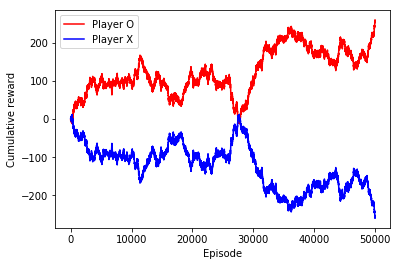

In [4]:
### Your code for Exercise 2a
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


def play():
    board = np.zeros(9, dtype=int)
    env = Tictactoe(board)
    r = RandomAgent()
    p = list(env.players.items())
    random.shuffle(p)
    for player, _ in itertools.cycle(p):
        available_actions = env.get_available_actions()
        move = r.choose_action(available_actions)
        env.make_move(player, move)
        if env.is_finished():
            reward = env.get_reward()
            return reward

num_episodes = 50000

results_O = np.zeros(num_episodes)
results_X = np.zeros(num_episodes)

for episode in range(num_episodes):
    reward = play()
    if reward == 0:
        results_O[episode] = reward
        results_X[episode] = reward
    elif reward == 1:
        results_O[episode] = reward
        results_X[episode] = -reward
    elif reward == -1:
        results_O[episode] = reward
        results_X[episode] = -reward

cum_results_O = np.cumsum(results_O)
cum_results_X = np.cumsum(results_X)

plt.plot(cum_results_O, color="red", label="Player O")
plt.plot(cum_results_X, color="blue", label="Player X")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.legend()
plt.show()

In a few sentences, discuss your results. Did you expect these results? Why or why not? (We will mark only the first three sentences. Please do not write any longer than that.) 


### Answer
The cumulative returns of player O and X are equal and opposite, as I expected for Tic-tac-toe which is a zero-sum game. Neither player has a clear advantage as the number of episodes increases because both players are random and who moves first is also random. It may appear that a player has a short-term advantage if their cumulative reward strays a long way from zero, but this is just random chance and will revert back to near zero in the long-run.



### Exercise 2b: Q-learning (20 marks)
Use Q-learning to learn an optimal policy for playing Tic-Tac-Toe against a random opponent. Produce a learning curve for your agent. That is, (1) plot average return as a function of episodes, (2) the learning curve should plot the average return of many agents (please specify how many agents you are averaging). 

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>
 

In [5]:
class QLearningAgent():
    def __init__(self, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q = np.zeros((19683, 9))
    
    def convert(self, state):
        conversion_vector = 3 ** np.arange(9)
        return int(state.dot(conversion_vector))
    
    def choose_action(self, available_actions, state):
        s = self.convert(state)
        
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(available_actions)
            return action
        else:
            qs = [self.getQ(s, action) for action in available_actions]
            maxQ = max(qs)
            if qs.count(maxQ) > 1:
                best = [i for i in range(len(available_actions)) if qs[i] == maxQ]
                i = random.choice(best)
            else:
                i = qs.index(maxQ)
        
        action = available_actions[i]
        return action
    
    def getQ(self, state, action):
        return self.q[state][action]
    
    def updateQ(self, state, new_state, reward, action, available_actions):
        s = self.convert(state)
        s_ = self.convert(new_state)
        qs = []
        for a in available_actions:
            qs.append(self.getQ(s_, a))
        if qs:
            max_next_Q = max(qs)
        else:
            max_next_Q = 0.0
        self.q[s][action] = ((1 - self.alpha) * self.q[s][action]) + (self.alpha * (reward + self.gamma * max_next_Q))


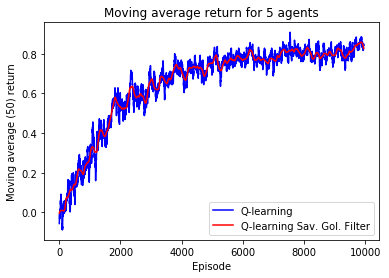

In [92]:
import scipy.signal as scipy
import matplotlib.pyplot as plt
%matplotlib inline


def play(q_agent, random_agent, n_episodes, board, random_restart=True):
    for episode in range(n_episodes):

        reward = 0
        board = np.copy(board)
        env = Tictactoe(board)
        #print(env.board)
        players = ["O", "X"]
        # Shuffle the players to get a random start
        if random_restart:
            random.shuffle(players)
        
        # If first player is the random agent, make a move
        if players[0] == "X":
            available_actions = env.get_available_actions()
            action = random_agent.choose_action(available_actions)
            env.make_move("X", action)
            
        while not env.is_finished():
            state = np.copy(env.board)
            #if (state==np.array([1, 2, 0, 0, 2, 0, 0, 1, 0])).all():
            #    print("Found the state")

            # Q-learning agent makes a move
            available_actions = env.get_available_actions()
            action = q_agent.choose_action(available_actions, state)
            env.make_move("O", action)
            new_state = np.copy(env.board)
            
            # If game is finished, random agent cannot make a move
            if env.is_finished():
                #print(new_state)
                reward = env.get_reward()
                reward_array_Q_020[episode] += reward

            else:
                # Random agent makes a move
                available_actions = env.get_available_actions()
                chosen_action = random_agent.choose_action(available_actions)
                env.make_move("X", chosen_action)
                new_state = np.copy(env.board)
                #print(new_state)
            
                #winner = env.check_win()
                if env.is_finished():
                    reward = env.get_reward()
                    reward_array_Q_020[episode] += reward

            available_actions = env.get_available_actions()
            #print(state, new_state, reward, action, available_actions)
            q_agent.updateQ(state, new_state, reward, action, available_actions)
            #print("Q value:", q_agent.Q[(tuple(state), action)])
    
    Q_array.append(q_agent.q)
    
    #print(q_agent.getQ(np.array([1, 2, 0, 0, 2, 0, 0, 1, 0]), 6))
    #s = q_agent.convert(np.array([1, 2, 0, 0, 2, 0, 0, 1, 0]))
    #print(q_agent.q[s])
    
    return q_agent

    
alpha = 0.1
gamma = 1.0
epsilon = 0.2
#initial_Q = 0

n_episodes = 10000
n_agents = 5

reward_array_Q_020 = np.zeros(n_episodes)
Q_array = []

# Game loop for each agent
for i in range(n_agents):

    random_agent = RandomAgent()
    q_agent = QLearningAgent(alpha, gamma, epsilon)
    board = np.zeros(9, dtype=int)
    #print(board)
    play(q_agent, random_agent, n_episodes, board, True)
    

# Moving average function is not mine and was taken from the following link:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_array_Q_020 = moving_average(reward_array_Q_020) / n_agents

sg_q_020 = scipy.savgol_filter(moving_average_array_Q_020,window_length=299,polyorder=3)

plt.plot(moving_average_array, color="blue", label="Q-learning")
plt.plot(sg_q, color="red", label="Q-learning Sav. Gol. Filter")
plt.title("Moving average return for "+ str(n_agents) + " agents")
plt.xlabel("Episode")
plt.ylabel("Moving average (50) return")
plt.legend()
plt.show()

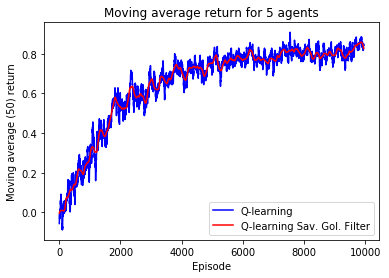

In [82]:
import scipy.signal as scipy
import matplotlib.pyplot as plt
%matplotlib inline


def play(q_agent, random_agent, n_episodes, board, random_restart=True):
    for episode in range(n_episodes):

        reward = 0
        board = np.copy(board)
        env = Tictactoe(board)
        #print(env.board)
        players = ["O", "X"]
        # Shuffle the players to get a random start
        if random_restart:
            random.shuffle(players)
        
        # If first player is the random agent, make a move
        if players[0] == "X":
            available_actions = env.get_available_actions()
            action = random_agent.choose_action(available_actions)
            env.make_move("X", action)
            
        while not env.is_finished():
            state = np.copy(env.board)
            #if (state==np.array([1, 2, 0, 0, 2, 0, 0, 1, 0])).all():
            #    print("Found the state")

            # Q-learning agent makes a move
            available_actions = env.get_available_actions()
            action = q_agent.choose_action(available_actions, state)
            env.make_move("O", action)
            new_state = np.copy(env.board)
            
            # If game is finished, random agent cannot make a move
            if env.is_finished():
                #print(new_state)
                reward = env.get_reward()
                reward_array_Q[episode] += reward

            else:
                # Random agent makes a move
                available_actions = env.get_available_actions()
                chosen_action = random_agent.choose_action(available_actions)
                env.make_move("X", chosen_action)
                new_state = np.copy(env.board)
                #print(new_state)
            
                #winner = env.check_win()
                if env.is_finished():
                    reward = env.get_reward()
                    reward_array_Q[episode] += reward

            available_actions = env.get_available_actions()
            #print(state, new_state, reward, action, available_actions)
            q_agent.updateQ(state, new_state, reward, action, available_actions)
            #print("Q value:", q_agent.Q[(tuple(state), action)])
    
    Q_array.append(q_agent.q)
    
    #print(q_agent.getQ(np.array([1, 2, 0, 0, 2, 0, 0, 1, 0]), 6))
    #s = q_agent.convert(np.array([1, 2, 0, 0, 2, 0, 0, 1, 0]))
    #print(q_agent.q[s])
    
    return q_agent

    
alpha = 0.1
gamma = 1.0
epsilon = 0.01
#initial_Q = 0

n_episodes = 10000
n_agents = 5

reward_array_Q = np.zeros(n_episodes)
Q_array = []

# Game loop for each agent
for i in range(n_agents):

    random_agent = RandomAgent()
    q_agent = QLearningAgent(alpha, gamma, epsilon)
    board = np.zeros(9, dtype=int)
    #print(board)
    play(q_agent, random_agent, n_episodes, board, True)
    

# Moving average function is not mine and was taken from the following link:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_array = moving_average(reward_array_Q) / n_agents

test = np.copy(moving_average_array)

sg_q = scipy.savgol_filter(moving_average_array,window_length=299,polyorder=3)

plt.plot(moving_average_array, color="blue", label="Q-learning")
plt.plot(sg_q, color="red", label="Q-learning Sav. Gol. Filter")
plt.title("Moving average return for "+ str(n_agents) + " agents")
plt.xlabel("Episode")
plt.ylabel("Moving average (50) return")
plt.legend()
plt.show()

In 3 sentences or less, (1) explain the state representation you used, (2) discuss the learning curve you produced. 

### Answer

My state representation is a numpy array of length 9 in which each value is from the set {0, 1, 2}, where 0 represents empty, 1 represents player O and 2 represents player X. My learning curve shows that the Q-learning agent learns quickly up to around episode 4000 before tailing off to an average return of around 0.7 (N.B. the average is a moving average of size 50). The curve is not smooth due to the random nature of the opponent and the exploratory nature of the Q-learning agent some of the time, which means that even if an agent was playing a perfect game they cannot win every time.

### Exercise 2c: Optimal policy (20 marks)
What is the optimal play for the agent in the following state? You must answer by writing a function that takes a state as input and _prints_ the "after-state" that would result from playing an optimal action. The printed output can be primitive but the board has to be somewhat recognizable.   <img src="images/tic_tac_toe.png" style="width: 80px;"/> 

In [7]:
def optimal_policy(state):
    qs = []
    random_agent = RandomAgent()
    q_agent = QLearningAgent(alpha, gamma, epsilon)
    board = np.copy(state)
    q = play(q_agent, random_agent, n_episodes, board, False)
    for i in range(9):
        qs.append(q.getQ(q.convert(board), i))
    optimal_action = qs.index(max(qs))
    board[optimal_action] = 1
    print(np.reshape(board, (3,3)))
    

state = np.array([1, 2, 0, 0, 2, 0, 0, 1, 0])
optimal_policy(state)

                                    

[[1 2 0]
 [0 2 0]
 [1 1 0]]


Please ignore this cell. We will use this cell to mark your answer. 


### Exercise 2d: Sarsa (40 marks)
Implement Sarsa to learn how to play Tic-tac-toe against a random player. Produce a learning curve. Also include the learning curve of your previously trained Q-learning agent in the same plot. Discuss the learning curves. For your reference, the pseudo-code for SARSA is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.4).
<img src="images/SARSA.png" style="width: 600px;"/>



In [69]:
class SarsaAgent():
    
    def __init__(self, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q = np.zeros((19683, 9))
    
    def convert(self, state):
        conversion_vector = 3 ** np.arange(9)
        return int(state.dot(conversion_vector))
    
    def choose_action(self, available_actions, state):
        #self.prev_state = state
        s = self.convert(state)
        
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(available_actions)
            return action
        else:
            qs = [self.getQ(s, action) for action in available_actions]
            maxQ = max(qs)
            if qs.count(maxQ) > 1:
                best = [i for i in range(len(available_actions)) if qs[i] == maxQ]
                i = random.choice(best)
            else:
                i = qs.index(maxQ)
        
        action = available_actions[i]

        return action
    
    
    def getQ(self, state, action):
        return self.q[state][action]
    
    def update(self, state, new_state, reward, action, action_):
        s = self.convert(state)
        s_ = self.convert(new_state)
        #print(self.q[s])
        '''qs = []
        for a in available_actions:
            qs.append(self.getQ(s_, a))
        if qs:
            max_next_Q = max(qs)
        else:
            max_next_Q = 0.0'''
        #if action_ == 9:
        #    q_ = 0.0
        #else:
        #    q_ = self.q[s_][action_]
        #print("Q  before:", self.q[s][action])
        #print("Q' before:", self.q[s_][action_])
        self.q[s][action] = ((1 - self.alpha) * self.q[s][action]) + (self.alpha * (reward + self.gamma * self.q[s_][action_]))
        #print("Q  after", self.q[s][action])

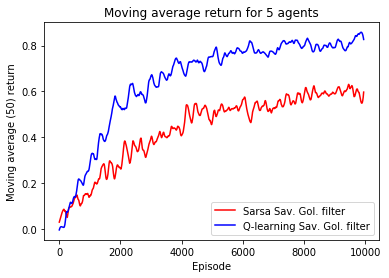

In [91]:
### Use this cell to produce the learning curve for Exercise 2d
import itertools
import scipy.signal as scipy
import matplotlib.pyplot as plt
%matplotlib inline


def play(sarsa_agent, random_agent, n_episodes, board):
    for episode in range(n_episodes):

        reward = 0
        board = np.copy(board)
        env = Tictactoe(board)
        players = ["O", "X"]
        # Shuffle the players to get a random start
        random.shuffle(players)
        
        
        # If first player is the random agent, make a move
        if players[0] == "X":
            available_actions = env.get_available_actions()
            action = random_agent.choose_action(available_actions)
            env.make_move("X", action)
            
        # Initialise s
        state = np.copy(env.board)
        #print(np.reshape(state, (3,3)))
        
        # Choose a
        available_actions = env.get_available_actions()
        action = sarsa_agent.choose_action(available_actions, state)
        #print(action)
            
        while not env.is_finished():
            
            '''# Initialise s
            state = np.copy(env.board)
            #print(state)
            
            # Choose a
            available_actions = env.get_available_actions()
            action = sarsa_agent.choose_action(available_actions, state)'''
            
            # Sarsa-learning agent makes a move
            env.make_move("O", action)
            # Observe new state
            new_state = np.copy(env.board)
            #print(np.reshape(new_state, (3,3)))
            # Observe reward
            if env.is_finished():
                reward = env.get_reward()
                #print("Reward:", reward)
                reward_array_S_020[episode] += reward
            else:

                # Random agent makes a move
                available_actions = env.get_available_actions()
                chosen_action = random_agent.choose_action(available_actions)
                #print(chosen_action)
                env.make_move("X", chosen_action)
                # Observe new state
                new_state = np.copy(env.board)
                #print(np.reshape(new_state, (3,3)))
                if env.is_finished():
                    reward = env.get_reward()
                    #print("Reward:", reward)
                    reward_array_S_020[episode] += reward
                
            # Choose a'
            available_actions = env.get_available_actions()
            if not env.is_finished():
                next_action = sarsa_agent.choose_action(available_actions, new_state)
            else:
                next_action = 0
            #print(next_action)
            
            #print(state, new_state, reward, action, next_action)
            sarsa_agent.update(state, new_state, reward, action, next_action)
            
            state = np.copy(new_state)
            action = next_action
    

    
alpha = 0.1
gamma = 1.0
epsilon = 0.20
#initial_Q = 0

n_episodes = 10000
n_agents = 5

reward_array_S_020 = np.zeros(n_episodes)

# Game loop for each agent
for i in range(n_agents):

    random_agent = RandomAgent()
    sarsa_agent = SarsaAgent(alpha, gamma, epsilon)
    board = np.zeros(9, dtype=int)
    play(sarsa_agent, random_agent, n_episodes, board)
    

# Moving average function is not mine and was taken from the following link:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
# Credit: Jaime
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_array_Sarsa_S_020 = moving_average(reward_array_S_020) / n_agents

sg_s_020 = scipy.savgol_filter(moving_average_array_Sarsa_S_020,window_length=299,polyorder=3)

#plt.plot(test, color="blue", label="Q-learning")
#plt.plot(moving_average_array_Sarsa, color="orange", label="Sarsa")
plt.plot(sg_s_020,color='r', label="Sarsa Sav. Gol. filter")
plt.plot(sg_q,color='b', label="Q-learning Sav. Gol. filter")
plt.title("Moving average return for "+ str(n_agents) + " agents")
plt.xlabel("Episode")
plt.ylabel("Moving average (50) return")
plt.legend()
plt.show()

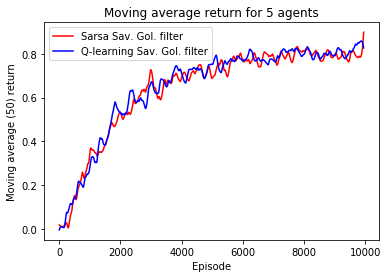

In [94]:
### Use this cell to produce the learning curve for Exercise 2d
import itertools
import scipy.signal as scipy
import matplotlib.pyplot as plt
%matplotlib inline


def play(sarsa_agent, random_agent, n_episodes, board):
    for episode in range(n_episodes):

        reward = 0
        board = np.copy(board)
        env = Tictactoe(board)
        players = ["O", "X"]
        # Shuffle the players to get a random start
        random.shuffle(players)
        
        
        # If first player is the random agent, make a move
        if players[0] == "X":
            available_actions = env.get_available_actions()
            action = random_agent.choose_action(available_actions)
            env.make_move("X", action)
            
        # Initialise s
        state = np.copy(env.board)
        #print(np.reshape(state, (3,3)))
        
        # Choose a
        available_actions = env.get_available_actions()
        action = sarsa_agent.choose_action(available_actions, state)
        #print(action)
            
        while not env.is_finished():
            
            '''# Initialise s
            state = np.copy(env.board)
            #print(state)
            
            # Choose a
            available_actions = env.get_available_actions()
            action = sarsa_agent.choose_action(available_actions, state)'''
            
            # Sarsa-learning agent makes a move
            env.make_move("O", action)
            # Observe new state
            new_state = np.copy(env.board)
            #print(np.reshape(new_state, (3,3)))
            # Observe reward
            if env.is_finished():
                reward = env.get_reward()
                #print("Reward:", reward)
                reward_array_S[episode] += reward
            else:

                # Random agent makes a move
                available_actions = env.get_available_actions()
                chosen_action = random_agent.choose_action(available_actions)
                #print(chosen_action)
                env.make_move("X", chosen_action)
                # Observe new state
                new_state = np.copy(env.board)
                #print(np.reshape(new_state, (3,3)))
                if env.is_finished():
                    reward = env.get_reward()
                    #print("Reward:", reward)
                    reward_array_S[episode] += reward
                
            # Choose a'
            available_actions = env.get_available_actions()
            if not env.is_finished():
                next_action = sarsa_agent.choose_action(available_actions, new_state)
            else:
                next_action = 0
            #print(next_action)
            
            #print(state, new_state, reward, action, next_action)
            sarsa_agent.update(state, new_state, reward, action, next_action)
            
            state = np.copy(new_state)
            action = next_action
    

    
alpha = 0.1
gamma = 1.0
epsilon = 0.01
#initial_Q = 0

n_episodes = 10000
n_agents = 5

reward_array_S = np.zeros(n_episodes)

# Game loop for each agent
for i in range(n_agents):

    random_agent = RandomAgent()
    sarsa_agent = SarsaAgent(alpha, gamma, epsilon)
    board = np.zeros(9, dtype=int)
    play(sarsa_agent, random_agent, n_episodes, board)
    

# Moving average function is not mine and was taken from the following link:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
# Credit: Jaime
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_array_Sarsa = moving_average(reward_array_S) / n_agents

sg_s = scipy.savgol_filter(moving_average_array_Sarsa,window_length=299,polyorder=3)

#plt.plot(test, color="blue", label="Q-learning")
#plt.plot(moving_average_array_Sarsa, color="orange", label="Sarsa")
plt.plot(sg,color='r', label="Sarsa Sav. Gol. filter")
plt.plot(sg_q,color='b', label="Q-learning Sav. Gol. filter")
plt.title("Moving average return for "+ str(n_agents) + " agents")
plt.xlabel("Episode")
plt.ylabel("Moving average (50) return")
plt.legend()
plt.show()

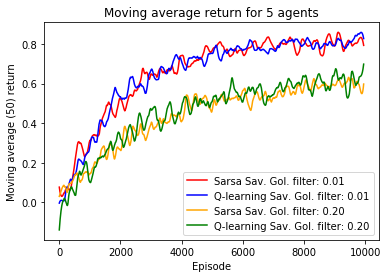

0.6498092654
0.652163601648
0.45281881218
0.439790171842


In [100]:
#plt.plot(test, color="blue", label="Q-learning: 0.01")
#plt.plot(moving_average_array_Sarsa, color="orange", label="Sarsa: 0.01")
#plt.plot(moving_average_array_Q_020, color="r", label="Q-learning: 0.20")
#plt.plot(moving_average_array_Sarsa_S_020, color="g", label="Sarsa: 0.20")
plt.plot(sg_s,color='r', label="Sarsa Sav. Gol. filter: 0.01")
plt.plot(sg_q,color='b', label="Q-learning Sav. Gol. filter: 0.01")
plt.plot(sg_s_020,color='orange', label="Sarsa Sav. Gol. filter: 0.20")
plt.plot(sg_q_020,color='g', label="Q-learning Sav. Gol. filter: 0.20")
plt.title("Moving average return for "+ str(n_agents) + " agents")
plt.xlabel("Episode")
plt.ylabel("Moving average (50) return")
plt.legend()
plt.show()

print(np.mean(test))
print(np.mean(moving_average_array_Sarsa))
print(np.mean(moving_average_array_Q_020))
print(np.mean(moving_average_array_Sarsa_S_020))

Discuss the learning curves here in 10 sentences or less.

### Answer

The learning curve shows an increasing average return with the number of episodes for both Q-Learning and Sarsa agents, with a positive, but decreasing gradient. Both agents learn at a similar rate, with a short period at the beginning where most moves are random since all Q-values start at 0 and so the updates have not propagated yet. The reason they are similar is that  Sarsa appears to learn slightly faster at the beginning before average returns level out for both agents at around 0.7-0.8 at 4000-5000 episodes. Since the agents have learned by this point, it is not worth increasing the number of episodes greatly as this will have very little effect on the average return (see Figure X). The learning curve is not smooth because of two factors: (i) playing against a random agent, and (ii) exploratory moves when epsilon > 0. These sources of randomness are also what causes the average return to not be equal to 1 once the agent's policy has converged to the optimal policy, meaning the average return would increase and the variation in returns would decrease if epsilon is lowered, which appears to be the case (see graph X). In addition, it is worth noting that I have used a moving average of size 50 in order to help smooth the graph out, which helps to draw inferences from the graphs as the 'noise' is reduced via this averaging.

Explain what I've done.

Save some graphs and use them in the explanation.

Try playing the Q-learning agent against the Sarsa agent.

Point to make: Sarsa is good when there is a potential large negative reward. It will be safe and avoid this. For example, the classic cliff problem. But there is not large negative reward in Tic Tac Toe, per se.

Higher average reward if just have greedy policy (i.e. epsilon = 0).

Appears that the lower the epsilon, Sarsa is a bit better than Q-learning.

Think about whether you should turn off learning once the agent's learning has converged to the optimal policy. And then let them play with their policies. Because is variation after learning just random noise?

What do the agent's converge to? Is there any difference?

MAKE SURE TO EITHER HAVE MOVING AVERAGE OR S-G.

In [ ]:
### Use this cell to produce the learning curve for Exercise 2d
import itertools
import scipy.signal as scipy
import matplotlib.pyplot as plt
%matplotlib inline


def play(SarsaAgent, QAgent, n_episodes, board):
    for episode in range(n_episodes):

        reward = 0
        board = np.copy(board)
        env = Tictactoe(board)
        players = ["O", "X"]
        # Shuffle the players to get a random start
        random.shuffle(players)
        
        state = np.copy(env.board)
        # If first player is the random agent, make a move
        if players[0] == "X":
            available_actions = env.get_available_actions()
            action = QAgent.choose_action(available_actions, state)
            env.make_move("X", action)
            
        # Initialise s
        state = np.copy(env.board)
        #print(np.reshape(state, (3,3)))
        
        # Choose a
        available_actions = env.get_available_actions()
        action = SarsaAgent.choose_action(available_actions, state)
        #print(action)
            
        while not env.is_finished():
            
            '''# Initialise s
            state = np.copy(env.board)
            #print(state)
            
            # Choose a
            available_actions = env.get_available_actions()
            action = sarsa_agent.choose_action(available_actions, state)'''
            
            # Sarsa-learning agent makes a move
            env.make_move("O", action)
            # Observe new state
            new_state = np.copy(env.board)
            #print(np.reshape(new_state, (3,3)))
            # Observe reward
            if env.is_finished():
                reward = env.get_reward()
                #print("Reward:", reward)
                Sarsa_reward_array[episode] += reward
                Q_reward_array[episode] += -reward
            else:

                # Random agent makes a move
                available_actions = env.get_available_actions()
                chosen_action = QAgent.choose_action(available_actions)
                #print(chosen_action)
                env.make_move("X", chosen_action)
                # Observe new state
                new_state = np.copy(env.board)
                #print(np.reshape(new_state, (3,3)))
                if env.is_finished():
                    reward = env.get_reward()
                    #print("Reward:", reward)
                    Sarsa_reward_array[episode] += reward
                    Q_reward_array[episode] += -reward
                
            # Choose a'
            available_actions = env.get_available_actions()
            if not env.is_finished():
                next_action = sarsa_agent.choose_action(available_actions, new_state)
            else:
                next_action = 0
            #print(next_action)
            
            #print(state, new_state, reward, action, next_action)
            sarsa_agent.update(state, new_state, reward, action, next_action)
            
            state = np.copy(new_state)
            action = next_action
    

    
alpha = 0.1
gamma = 1.0
epsilon = 0.0
#initial_Q = 0

n_episodes = 10000
n_agents = 5

Sarsa_reward_array = np.zeros(n_episodes)
Q_reward_array = np.zeros(n_episodes)

# Game loop for each agent
for i in range(n_agents):

    QAgent = QLearningAgent()
    SarsaAgent = SarsaAgent(alpha, gamma, epsilon)
    board = np.zeros(9, dtype=int)
    play(SarsaAgent, QAgent, n_episodes, board)
    

# Moving average function is not mine and was taken from the following link:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
# Credit: Jaime
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_array_Sarsa = moving_average(reward_array_S) / n_agents

sg = scipy.savgol_filter(moving_average_array_Sarsa,window_length=299,polyorder=3)

#plt.plot(test, color="blue", label="Q-learning")
#plt.plot(moving_average_array_Sarsa, color="orange", label="Sarsa")
plt.plot(sg,color='r', label="Sarsa Sav. Gol. filter")
plt.plot(sg_q,color='b', label="Q-learning Sav. Gol. filter")
plt.title("Moving average return for "+ str(n_agents) + " agents")
plt.xlabel("Episode")
plt.ylabel("Moving average (50) return")
plt.legend()
plt.show()